# 傾向スコアマッチング

## 問題設定
- 「テレビCMの接触有無」と「スマートフォンでのアプリ利用」の因果効果を推定する。
    - 予算や資源制約が存在する状況で、最も効率の高い施策を実施する状況が想定される問題設定。

### その他、効果検証に関するメモ
- CMの費用対効果を考えるのであれば、ATEよりも「CM接触によるアプリ使用時間の伸び」であるATTの方が有効


## 用語
- ATE：平均処置効果
    - 対象母集団のすべての人に介入した場合の平均因果効果
    - 「（すべての人に介入を行った場合）ー（すべての人に介入を行わなかった場合）」
- ATT：処置群における平均処置効果
    - 対象母集団の介入群に対しての平均因果効果
    - 「（介入群の平均処置効果）ー（介入群に処置しなかった場合の平均処置効果）」

## ライブラリをインポート

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))
import urllib.request

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## サンプルデータの取得

In [2]:
def download_file(url, filepath):
    urllib.request.urlretrieve(url, filepath)

In [3]:
url = "https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv"
filepath = "../data/sample.csv"

if not os.path.exists(filepath):
    download_file(url, filepath)

raw_df = pd.read_csv(filepath)

In [4]:
print(f'データサイズ: {raw_df.shape[0]:,}')
raw_df.head()

データサイズ: 10,000


,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


## 単純な平均値の差を取る問題点

In [5]:
print('CM接触者数とアプリ使用者数の関係')
pd.pivot_table(
    raw_df.reset_index(), 
    values='index', 
    index=['cm_dummy'], 
    columns=['gamedummy'],
    aggfunc=['count'],
    margins=True
)

CM接触者数とアプリ使用者数の関係


count            
gamedummy     0    1    All
cm_dummy                   
0          5428  428   5856
1          3832  312   4144
All        9260  740  10000

上記のデータからわかること。

- 対象サンプルは、10,000人
- 全体のCM接触者は、4,144人
- アプリ利用者は、740人

In [6]:
print('CM接触有無によるアプリ使用状況との関係')
raw_df.groupby('cm_dummy')[
    'gamedummy', 'gamecount', 'gamesecond'
].agg(['mean', 'std']).T.round(3)

CM接触有無によるアプリ使用状況との関係


cm_dummy                 0          1
gamedummy  mean      0.073      0.075
           std       0.260      0.264
gamecount  mean     10.048      8.564
           std      55.267     53.331
gamesecond mean   3107.706   2478.066
           std   19496.772  15564.015

- CMを見た人のアプリ利用時間：2,478
- CMを見なかった人のアプリ利用時間：3,107

となっており、CMを見たことで 629秒アプリの使用時間が短くなった。

しかしこれは明らかに不自然な結果といえる。

## セレクションバイアス

グラフからわかる通り、CM非接触群はそもそもテレビを見ない人が多い。

In [7]:
raw_df.groupby('cm_dummy')[
    'TVwatch_day', 'area_kanto', 'area_keihan', 'area_tokai', 'area_keihanshin'
].agg(['mean', 'std']).T.round(3)

cm_dummy                     0          1
TVwatch_day     mean  5714.982  11461.881
                std   5690.371   8851.091
area_kanto      mean     0.063      0.131
                std      0.243      0.337
area_keihan     mean     0.509      0.701
                std      0.500      0.458
area_tokai      mean     0.124      0.093
                std      0.330      0.291
area_keihanshin mean     0.303      0.075
                std      0.460      0.263

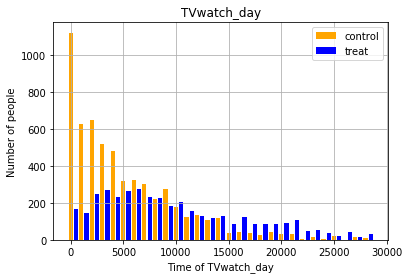

In [8]:
plot_df = raw_df.copy()
plt.title('TVwatch_day')
plt.ylabel('Number of people')
plt.xlabel('Time of TVwatch_day')
plot_df.loc[plot_df['cm_dummy']==0, 'TVwatch_day'].hist(
    bins=np.arange(0, 30000, 1000), align='left', rwidth=0.4, color='orange', label='control')
plot_df.loc[plot_df['cm_dummy']==1, 'TVwatch_day'].hist(
    bins=np.arange(0, 30000, 1000), align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

## 平均処置効果ATEの推定

岩波データサイエンス vol.03 に合わせて、IPWによるセレクションバイアスを補正した因果効果の推定を行う。

In [238]:
%load_ext autoreload
%autoreload
from libs import PropensityScoreMatching

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [262]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

In [308]:
drop_data = raw_df[['gamedummy', 'gamesecond', 'gamecount']]

use_cols = [
    'cm_dummy', 'TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc', 'pmoney', 'area_kanto',
    'area_tokai', 'area_keihanshin', 'job_dummy1', 'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5',
    'job_dummy6', 'job_dummy7', 'fam_str_dummy1', 'fam_str_dummy2','fam_str_dummy3', 'fam_str_dummy4'
]

In [309]:
treatment = 'cm_dummy'

model = LogisticRegression
params = {'solver': 'lbfgs', 'max_iter': 1000, 'random_state': 7}
scaler = preprocessing.MinMaxScaler()

pscore_model = PropensityScoreMatching(raw_df[use_cols], treatment)
pscore_model.fit(model, params, scaler)
transformed_df = pscore_model.predict(threshold=None)

In [310]:
print(transformed_df.shape)
transformed_df.head()

(11712, 23)


,cm_dummy,TVwatch_day,age,sex,marry_dummy,child_dummy,inc,pmoney,area_kanto,area_tokai,...,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,p_score
0,1,6877.865092,34.5,1,0,0,249.5,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0.058415
1,1,5714.163247,34.5,1,1,1,549.5,2.0,0,1,...,0,0,0,0,0,0,0,1,0,0.262466
2,1,3257.376396,34.5,0,0,0,249.5,6.5,0,1,...,1,0,0,0,0,0,0,0,1,0.188688
3,1,6738.858728,54.5,0,0,1,0.0,2.0,0,1,...,0,0,0,0,0,0,0,0,1,0.234179
4,1,4619.352745,34.5,1,1,1,449.5,4.0,0,1,...,0,0,0,0,0,0,0,1,0,0.249318


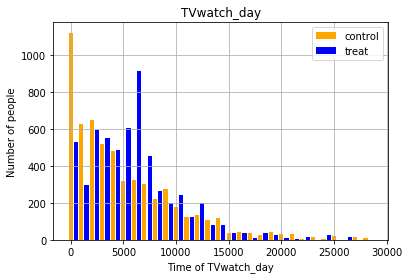

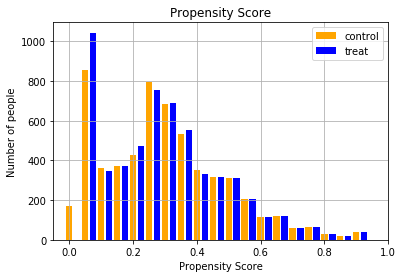

In [311]:
plot_df = transformed_df.copy()
plt.title('TVwatch_day')
plt.ylabel('Number of people')
plt.xlabel('Time of TVwatch_day')
plot_df.loc[plot_df['cm_dummy']==0, 'TVwatch_day'].hist(
    bins=np.arange(0, 30000, 1000), align='left', rwidth=0.4, color='orange', label='control')
plot_df.loc[plot_df['cm_dummy']==1, 'TVwatch_day'].hist(
    bins=np.arange(0, 30000, 1000), align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

plt.title('Propensity Score')
plt.ylabel('Number of people')
plt.xlabel('Propensity Score')
plt.xlim(-0.05, 1.0)
plot_df.loc[plot_df['cm_dummy']==0, 'p_score'].hist(
    bins=np.arange(0, 1, 0.05), align='left', rwidth=0.4, color='orange', label='control')
plot_df.loc[plot_df['cm_dummy']==1, 'p_score'].hist(
    bins=np.arange(0, 1, 0.05), align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

上記の図から、テレビの視聴時間と合わせて、傾向スコアの分布も２群間で揃っていることがわかる。

続いて、平均処置効果（ATE）を推定する。

In [313]:
# temp = pscore_model.df

# sum(temp['cm_dummy']*temp[outcome]/temp['p_score']) / sum(temp['cm_dummy']/temp['p_score']) - \
#     sum((1-temp['cm_dummy'])*temp[outcome]/(1-temp['p_score'])) / sum( (1-temp['cm_dummy'])/(1-temp['p_score']) )

In [314]:
# sum(temp['cm_dummy']*temp[outcome]/temp['p_score']) / sum(temp['cm_dummy']/temp['p_score']) - \
#     sum((temp['cm_dummy'])*temp[outcome]/(1-temp['p_score'])) / sum( (temp['cm_dummy'])/(1-temp['p_score']) )

In [315]:
'''ATE'''
from sklearn.linear_model import LinearRegression

temp = pscore_model.df
temp = pd.concat([temp, drop_data], axis=1)
weight = np.where(temp['cm_dummy']==1, 1/temp['p_score'], 1/(1-temp['p_score']))

reg = LinearRegression(fit_intercept=False).fit(
    pd.get_dummies(temp['cm_dummy']), temp[outcome], 
    sample_weight=weight
)

print('cm_dummy==0: ', reg.predict([[1, 0]]))
print('cm_dummy==1: ', reg.predict([[0, 1]]))
print('diff: ', reg.predict([[0, 1]]) - reg.predict([[1, 0]]))

print('')

reg = LinearRegression(fit_intercept=True).fit(
    temp['cm_dummy'].to_frame(), temp[outcome], 
    sample_weight=weight
)

print('cm_dummy==0: ', reg.predict([[0]]))
print('cm_dummy==1: ', reg.predict([[1]]))
print('diff: ', reg.predict([[1]]) - reg.predict([[0]]))

cm_dummy==0:  [2691.40711865]
cm_dummy==1:  [3959.15531251]
diff:  [1267.74819386]

cm_dummy==0:  [2691.40711865]
cm_dummy==1:  [3959.15531251]
diff:  [1267.74819386]


In [316]:
'''ATT'''
from sklearn.linear_model import LinearRegression

temp = pscore_model.df
temp = pd.concat([temp, drop_data], axis=1)
weight = np.where(temp['cm_dummy'], 1, temp['p_score']/(1-temp['p_score']))

reg = LinearRegression(fit_intercept=False).fit(
    pd.get_dummies(temp['cm_dummy']), temp[outcome], 
    sample_weight=weight
)

print('cm_dummy==0: ', reg.predict([[1, 0]]))
print('cm_dummy==1: ', reg.predict([[0, 1]]))
print('diff: ', reg.predict([[0, 1]]) - reg.predict([[1, 0]]))

print('')

reg = LinearRegression(fit_intercept=True).fit(
    temp['cm_dummy'].to_frame(), temp[outcome], 
    sample_weight=weight
)

print('cm_dummy==0: ', reg.predict([[0]]))
print('cm_dummy==1: ', reg.predict([[1]]))
print('diff: ', reg.predict([[1]]) - reg.predict([[0]]))

cm_dummy==0:  [2170.99543494]
cm_dummy==1:  [2478.06587838]
diff:  [307.07044344]

cm_dummy==0:  [2170.99543494]
cm_dummy==1:  [2478.06587838]
diff:  [307.07044344]
